# Project NoteBook
## Data Input

The datasets used in this project are available from ['The Cancer Genome Atlas' (TCGA)](www.http://cancergenome.nih.gov/) consortium.  Clinical and RNA-seq gene count data sets can be downloaded via a provided data portal, or using an R package called [TCGA2STAT](https://cran.r-project.org/web/packages/TCGA2STAT/index.html).  The R script used to download the data sets for this project are available in the local repository for this project ([GitHub link](https://github.com/CCThompson82/Prostate_metastasis/tree/master/Dataset_setup)).  If run locally, two [feather](https://github.com/wesm/feather) files will be written to the working directory, which will be read and imported with the python scripts below.

In [1]:
%run -i Dataset_cleanup/cleanup_clinical.py

Clinical data set imported!

 The following features do not provide any information: 
 ['Composite.Element.REF' 'ethnicity' 'gender' 'pathologicstage'
 'pathologyMstage' 'tumortissuesite'] 

Variables that are not known at initial diagnosis: 
 ['daystodeath' 'daystolastfollowup' 'daystopsa' 'gleasonscore'
 'histologicaltype' 'numberoflymphnodes' 'pathologyTstage'
 'radiationtherapy' 'residualtumor' 'vitalstatus'] 

Variables that are known at the time of diagnosis:
 ['dateofinitialpathologicdiagnosis' 'psavalue' 'race' 'yearstobirth']

Dimensions of clinical dataframe: (499, 7)


In [2]:
%run -i Dataset_cleanup/cleanup_gene_counts.py

Gene Counts data set imported!

Dimension of DataFrame: (497, 20501) 

Transformation Successful!

497 Gene count estimate profiles have been transformed from transcript abundance estimates to transcripts per million reads (TPM)


## Dataset preparation
### Clinical Information
There is missing clinical data in many of the features, including what will become the outcome label ('pathologyNstage' - metastasis state).  The series **'y_all'** is the full list of pathologyNstage, where 'n1' represents metastasis, and 'n0' represents no metastasis observed to date.  Some observations have no metastasis state recorded and are represented by NaN in y_all.  These are removed for the trimmed **'y_labels'** series.  

The **'clinical'** dataset is trimmed to include only those patients where a metastasis state is known.  Then the data set is trimmed further to remove observations where feature data is missing to yield the dataframe, **'clin_df'**.  Finally, 'y_labels' is trimmed to only those patients that exist in 'clin_df' to yield, **'y_clin'**.

In [3]:
print("Total observations in original dataset:",clinical.shape[0])

not_labeled = y_all[y_all.isnull()] 
y_labels = y_all[y_all.notnull()]

print("\nObservations with metastasis label:",y_labels.shape[0])
print("\nUnlabeled observations (removed:)",not_labeled.shape[0])


Total observations in original dataset: 499

Observations with metastasis label: 426

Unlabeled observations (removed:) 73


In [4]:
clinical = clinical.loc[y_labels.index]  #filter only observations where metastasis state is known
print("Filtering out missing metastasis state labels left",clinical.shape[0],"observations")

clin_df = clinical.dropna(inplace = False) # Remove all observations where clinical data is missing
print("Removing NaN rows leaves ",clin_df.shape[0]," observations in the feature set.") 

y_clin = y_labels.loc[clin_df.index] #remove metastasis labels where no clinical data now exists due to NaN removal.

Filtering out missing metastasis state labels left 426 observations
Removing NaN rows leaves  359  observations in the feature set.


### TPM dataset
The original dataset, **'X_all'**, includes the transformed transcript per million (TPM) estimates for all RNA-seq profiles.  This dataset is trimmed to include only those observations where a finite y label exists, to yield **'X'**.  Additionally, X_all was scaled to mean = zero, standard variance as **'X_scaled_all'**.  This data set was trimmed to the relevant observations in **'X_scaled'**.  Finally, a test was run to ensure barcodes were not duplicated in the base, 'X' data set. 

In [5]:
"""Limit X to only observations where a target label is present."""
X = X_all.loc[list(y_labels.index)]  #Only observations that also have a known metastasis state are kept.
X.dropna(axis=0, inplace=True)

In [6]:
"""Scale TPM counts in X to mean = 0 and standard variance"""
from sklearn.preprocessing import scale
X_scaled_all = pd.DataFrame(scale(X_all), columns = X_all.columns, index = [X_all.index])
X_scaled = X_scaled_all.loc[X.index]

In [7]:
"""Ensure target labels correspond to an observation in X"""
y = y_labels[X.index] #only labels that are in X are kept.  
y_all = y_all[X_all.index]


In [8]:
"""Test on DataFrame"""
def duplicate_TCGA_ID_test(X) :
    seen = set()
    uniq = []
    duplicates = []
    for x in X.index:
        if x not in seen:
            uniq.append(x)
            seen.add(x)
        else:
            duplicates.append(x)
    if len(duplicates) > 0 :
        print("Error in data set arrangement")
    else :
        print("TPM count dataset contains",X.shape[0],"uniquely barcoded observations.")

duplicate_TCGA_ID_test(X)

TPM count dataset contains 424 uniquely barcoded observations.


### Feature Reduction


In [9]:
from sklearn.feature_selection import SelectKBest, f_classif

In [10]:
K_selector = SelectKBest(f_classif, k = 5000)
K_selector.fit(X, y)

/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 1595  1815  2267  4324  4341  4342  4343  4344  4345  4346  4347  4779
  4780  4781  4782  4787  4790  4791  4794  4795  4801  4803  5259  6032
  6776  6780  6783  7445  7551  7632  7633  7634  7635  7636  7732  9275
  9277  9287  9291  9292  9419  9421  9423  9495 10092 11101 11929 12028
 12488 12527 12584 12593 12599 12601 12606 12635 12692 13749 13963 14015
 14129 14130 14131 14132 14726 14727 14729 15109 15111 15112 16536 16538
 16539 16541 16542 16543 16545 16546 16547 16548 16549 16550 16576 16605
 16608 16648 16668 16669 16670 16671 16672 16673 16674 16675 16676 16677
 16678 16679 16680 16681 16682 16683 16684 16685 16686 16687 16688 16689
 16690 16691 16692 16693 16694 16695 16696 16697 16698 16699 16700 16701
 16702 16703 16704 16705 16706 16707 16708 16709 16710 16711 16712 16713
 16714 16715 16716 16717 16718 16720 16721 16722 16723 16724 16725 

SelectKBest(k=5000, score_func=<function f_classif at 0x11613c8c8>)

In [11]:
X_k = pd.DataFrame(K_selector.transform(X_scaled), index = X_scaled.index)
print(X_k.shape, y.shape)

(424, 5000) (424,)


In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=50, 
          copy=True, 
          whiten=False)

In [14]:
X_pca = pd.DataFrame(pca.fit_transform(X_k)) #fit PCA vs whole data set and transform only the set that has feature labels associated.
print(X_pca.shape)

(424, 50)


#### DataFrames for project:
**'Clinical'** : feature variables that would be known at time of diagnosis.  Observations limited to those where a label exists for metastasis state. (associated with y_labels) 

**'clin_df'** : Clinical data with NaN dropped. (associated with y_clin) 

**y_all** : Target labels for entire cohort (includes NaN).

**'y_labels'** : all observations of metastasis state regardless of missing clinical or gene count data.

**y_clin** : all target labels where clinical information is not NaN.

**gene_counts** : unscaled, untransformed estimated transcript abundance counts uploaded from TCGA portal (RSEM)

**X_all** : raw estimated abundance transformed to estimated transcripts per million transcripts (TPM).  Observations include all in data set, regardless of whether a label for metastasis state has also been recorded for the patient. 

**X** : Observations from X_all are limited to those that also have a finite target label.  

**X_scaled** : All TPM counts have been transformed to mean = 0, standard unit variance.

**y** : all y_labels where observation exists for X

### Graphical Analysis of Principle Components

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

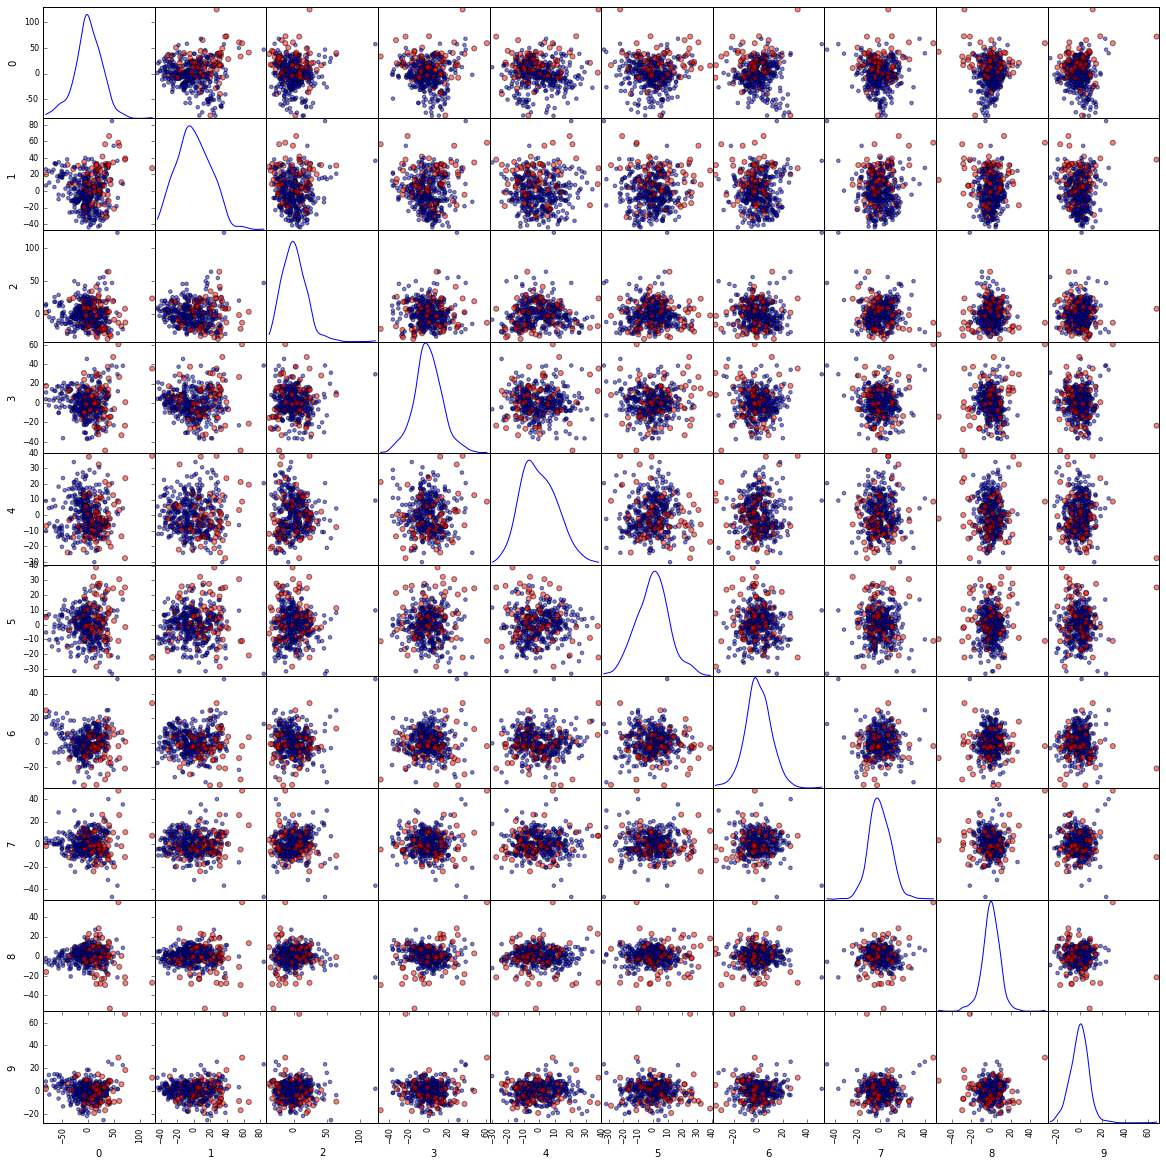

In [16]:
c_dict = {'n1' : 'red', 'n0' : 'blue'}
s_dict = {'n1' : 100, 'n0' : 50}
col_label = list(y.replace(c_dict, inplace = False))
s_label = list(y.replace(s_dict, inplace = False))

sm = pd.scatter_matrix(X_pca.iloc[:,0:10], alpha=0.5, figsize= (20,20), diagonal = 'kde', c = col_label, s = s_label)

## Benchmark Analysis of initial clinical presentation for  predictors of metastasis

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, make_scorer, accuracy_score, f1_score, matthews_corrcoef, fbeta_score, classification_report

In [18]:
recaller = make_scorer(recall_score, greater_is_better=True, needs_proba=False, needs_threshold=False, pos_label='n1')
acc_scorer = make_scorer(accuracy_score, greater_is_better=True, needs_proba=False, needs_threshold=False)
f1_scorer = make_scorer(f1_score, greater_is_better=True, needs_proba=False, needs_threshold=False, pos_label='n1')
matthews_cor_scorer = make_scorer(matthews_corrcoef, greater_is_better=True, needs_proba=False, needs_threshold=False)
fbeta_scorer = make_scorer(fbeta_score, greater_is_better=True, needs_proba=False, needs_threshold=False, pos_label='n1', beta = 2)

In [19]:
clf = DecisionTreeClassifier(criterion='gini',
                            splitter='best',
                            max_depth=None,
                            min_samples_split=30,
                            min_samples_leaf=1,
                            min_weight_fraction_leaf=0.0,
                            max_features=None,
                            random_state=None,
                            max_leaf_nodes=None,
                            class_weight='balanced', #avoids the classifier being rewarded for choosing the most prevelant class each instance (n0)
                            presort=False)
recall_vals = cross_val_score(clf, clin_df, y_clin, scoring=recaller, cv=5)
accuracy_vals = cross_val_score(clf, clin_df, y_clin, scoring=acc_scorer, cv=5)
f1_vals = cross_val_score(clf, clin_df, y_clin, scoring = f1_scorer, cv =5)
fbeta_vals = cross_val_score(clf, clin_df, y_clin, scoring = fbeta_scorer, cv =5)
mcc_vals = cross_val_score(clf, clin_df, y_clin, scoring = matthews_cor_scorer, cv =5)
print('Recall_n1:  ',recall_vals.mean())
print('\nModel Accuracy score:  ',accuracy_vals.mean())
print('\nModel F1 Score (n1): ',f1_vals.mean())
print('\nMatthews Correlation Coefficient Score: ',mcc_vals.mean())
print('\nFbeta score (n1): ', fbeta_vals.mean())


Recall_n1:   0.465384615385

Model Accuracy score:   0.542113640749

Model F1 Score (n1):  0.240793194691

Matthews Correlation Coefficient Score:  0.0041604510029

Fbeta score (n1):  0.332833617686


## Generate Models

### Test Train Split

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
print(X_pca.shape, y.shape)

(424, 50) (424,)


In [22]:
train_k = round(len(y)*5 /6) #5/6 of set dedicated to training set
test_k = len(y) - train_k #1/6 of set dedicated to test set

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_k, y, 
                                                    test_size= test_k, 
                                                    train_size = train_k,
                                                    random_state = 123,
                                                    stratify = y)
Xpca_train, Xpca_test, ypca_train, ypca_test = train_test_split(X_pca, y, 
                                                    test_size= test_k, 
                                                    train_size = train_k,
                                                    random_state = 123,
                                                    stratify = y)

In [37]:
%run -i SVM/SVM.py

             precision    recall  f1-score   support

         n0       0.96      0.86      0.91       287
         n1       0.59      0.85      0.70        66

avg / total       0.89      0.86      0.87       353


F beta:  0.779944289694

MCC:  0.626447747565


### AdaBoost

In [25]:
%run -i AdaBoost/adaboost.py

             precision    recall  f1-score   support

         n0       0.94      0.55      0.69       287
         n1       0.30      0.85      0.44        66

avg / total       0.82      0.60      0.65       353

F beta:  0.622222222222

MCC:  0.308866029251


### Random Forest

In [26]:
%run -i Random_Forest/RF.py

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

              precision    recall  f1-score   support

         n0       0.95      0.91      0.93       287
         n1       0.67      0.79      0.72        66

avg / total       0.90      0.89      0.89       353


F beta:  0.760233918129

MCC:  0.655255229773


### Logistic Regression

In [27]:
%run -i LogReg_gleason/LogReg_GS.py

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
             precision    recall  f1-score   support

         n0       0.92      0.84      0.88       287
         n1       0.49      0.70      0.58        66

avg / total       0.84      0.81      0.82       353


F beta:  0.644257703081

MCC:  0.471932959639


## Test for the best model

In [28]:
print(classification_report(y_test,
                            LR_clf.predict(logisticDF_test),
                            target_names = ['n0', 'n1']))
print('F beta: ', fbeta_score(y_test, LR_clf.predict(logisticDF_test), beta = 2, pos_label='n1'))
print('MCC: ',matthews_corrcoef(y_test, LR_clf.predict(logisticDF_test)))

             precision    recall  f1-score   support

         n0       0.94      0.86      0.90        58
         n1       0.56      0.77      0.65        13

avg / total       0.87      0.85      0.85        71

F beta:  0.714285714286
MCC:  0.561238031151


In [29]:
print(classification_report(ypca_test,
                            clf_svm.predict(Xpca_test),
                            target_names = ['n0', 'n1']))

print('F beta: ', fbeta_score(ypca_test, clf_svm.predict(Xpca_test), beta = 2, pos_label='n1'))
print('MCC: ',matthews_corrcoef(ypca_test, clf_svm.predict(Xpca_test)))

             precision    recall  f1-score   support

         n0       0.94      0.83      0.88        58
         n1       0.50      0.77      0.61        13

avg / total       0.86      0.82      0.83        71

F beta:  0.694444444444
MCC:  0.513129230423


In [30]:
print(classification_report(y_test,
                            RF_clf.predict(X_test),
                            target_names = ['n0', 'n1']))
print('F beta: ', fbeta_score(y_test, RF_clf.predict(X_test), beta = 2, pos_label='n1'))
print('MCC: ',matthews_corrcoef(y_test, RF_clf.predict(X_test)))

             precision    recall  f1-score   support

         n0       0.92      0.93      0.92        58
         n1       0.67      0.62      0.64        13

avg / total       0.87      0.87      0.87        71

F beta:  0.625
MCC:  0.563890676931


In [31]:
print(classification_report(y_test,
                            ada_clf.predict(X_test),
                            target_names = ['n0', 'n1']))
print('F beta: ', fbeta_score(y_test, ada_clf.predict(X_test), beta = 2, pos_label='n1'))
print('MCC: ',matthews_corrcoef(y_test, ada_clf.predict(X_test)))

             precision    recall  f1-score   support

         n0       0.88      0.66      0.75        58
         n1       0.29      0.62      0.39        13

avg / total       0.77      0.65      0.69        71

F beta:  0.5
MCC:  0.214107189661


## Generate a Voting Classifier and Test for performance

In [38]:
clf_dict = {'AdaBoost' : {'model': ada_clf, 
                          'input_set': X_train, 
                          'label_set' : y_train, 
                          'weight' : 0.05}, 
            'Random_Forest' : {'model': RF_clf, 
                          'input_set': X_train, 
                          'label_set' : y_train, 
                          'weight' : .25}, 
            'LogReg' : {'model': LR_clf, 
                          'input_set': logisticDF, 
                          'label_set' : y_train, 
                          'weight' : .35}, 
            'SVM' : {'model': clf_svm, 
                          'input_set': Xpca_train, 
                          'label_set' : ypca_train, 
                          'weight' : .35}}
test_dict ={'AdaBoost' : {'model': ada_clf, 
                          'input_set': X_test, 
                          'label_set' : y_test, 
                          'weight' : 0.05}, 
            'Random_Forest' : {'model': RF_clf, 
                          'input_set': X_test, 
                          'label_set' : y_test, 
                          'weight' : .25}, 
            'LogReg' : {'model': LR_clf, 
                          'input_set': logisticDF_test, 
                          'label_set' : y_test, 
                          'weight' : .35}, 
            'SVM' : {'model': clf_svm, 
                          'input_set': Xpca_test, 
                          'label_set' : ypca_test, 
                          'weight' : .35}}

In [39]:

def voter(clf_dict) :
    """Test labels are in same order"""
    pass
    
    df = pd.DataFrame()
    weights = []
    for model in clf_dict.items() :
        #print(model[0])
        df[model[0]] = model[1]['model'].predict_proba(model[1]['input_set'])[:,1]
        #index = model[1]['label_set'].index
        #df[model[0]].replace({'n1':1,'n0':0}, inplace = True)
        df[model[0]] = df[model[0]].apply(lambda x : x*model[1]['weight'])
        weights.append(model[1]['weight'])
    df.set_index(clf_dict['SVM']['label_set'].index, inplace=True)
    df['Weighted_Vote'] = df.apply(lambda x : sum(x)/np.sum(weights), axis = 1)
    df['actual_y'] = list(clf_dict['SVM']['label_set'])
    df['called_y'] = df['Weighted_Vote'].apply(lambda x : x >= 0.4)
    df['called_y'] = df['called_y'].replace({False : 'n0', True : 'n1'})
    #print(df.tail(10))
    print('\nMCC: ',matthews_corrcoef(df['actual_y'], df['called_y']))
    print('\nF beta: ',fbeta_score(df['actual_y'], df['called_y'], beta = 2, pos_label='n1'))
    print('\nClass_report:\n ',classification_report(df['actual_y'], df['called_y']))


In [40]:
voter(clf_dict)


MCC:  0.573620640786

F beta:  0.689149560117

Class_report:
               precision    recall  f1-score   support

         n0       0.93      0.90      0.91       287
         n1       0.61      0.71      0.66        66

avg / total       0.87      0.86      0.87       353



In [41]:
voter(test_dict)


MCC:  0.647115664966

F beta:  0.746268656716

Class_report:
               precision    recall  f1-score   support

         n0       0.95      0.91      0.93        58
         n1       0.67      0.77      0.71        13

avg / total       0.90      0.89      0.89        71

